In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler



In [2]:
# Load the dataset
df = pd.read_csv('train.csv')


<Figure size 1200x1200 with 0 Axes>

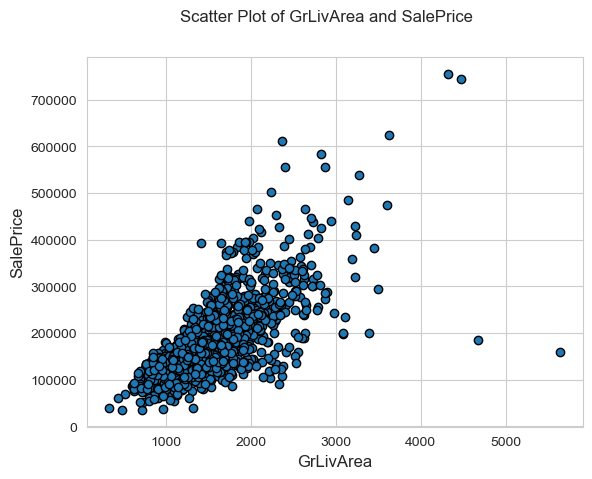

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
edgecolor = 'black'

fig = plt.figure(figsize=(12,12))

#function to plot scatter plot between a feature and the Sale Price 
def scatter_plot(a):
    fig, ax = plt.subplots()
    ax.scatter(x = df[a], y = df['SalePrice'], edgecolor=edgecolor)
    plt.ylabel('SalePrice', fontsize=12)
    plt.xlabel(a, fontsize=12)
    plt.suptitle("Scatter Plot of "+ a + " and SalePrice")
    plt.show()
scatter_plot('GrLivArea')

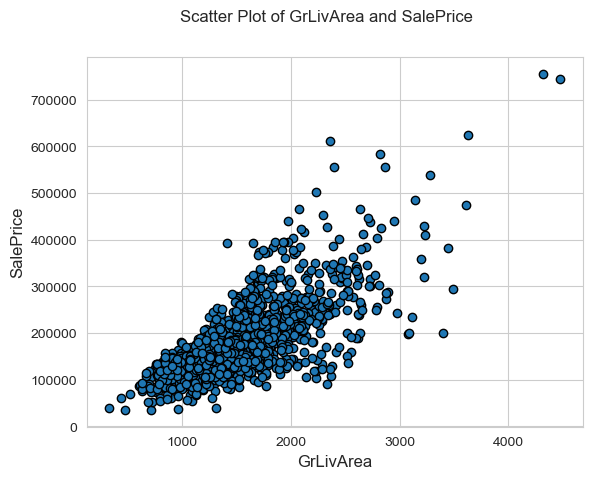

In [4]:
#Deleting outliers

df =  df.drop( df[( df['GrLivArea'] > 4000) & ( df['SalePrice']<300000)].index)
scatter_plot('GrLivArea')

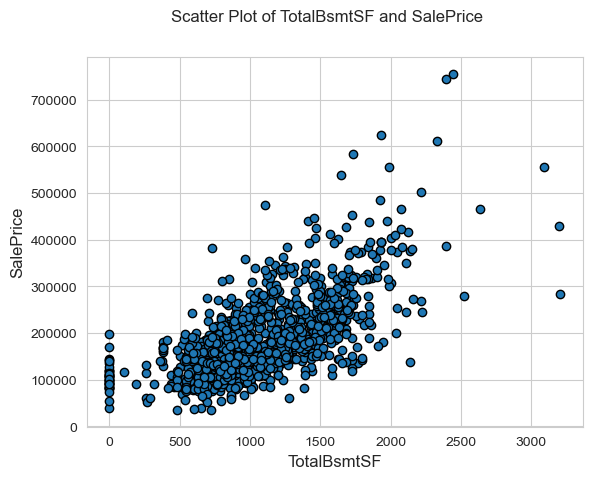

In [5]:
scatter_plot('TotalBsmtSF')

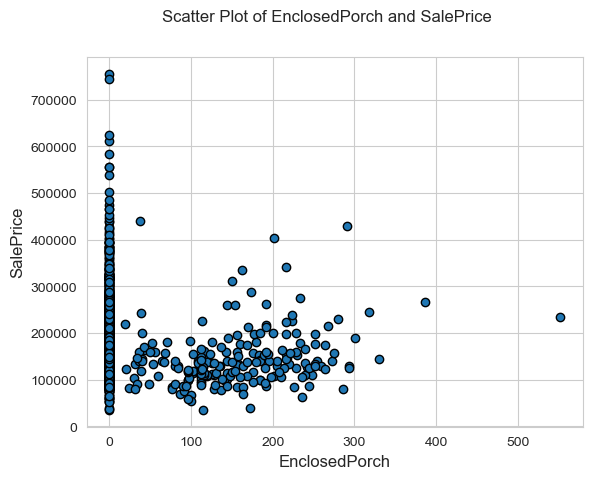

In [6]:
scatter_plot('EnclosedPorch')

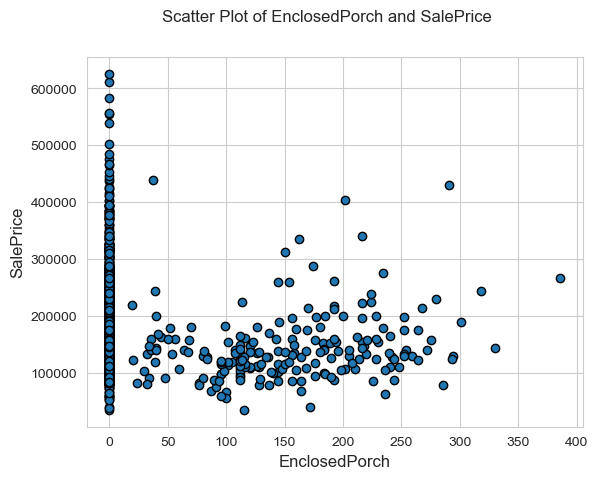

In [7]:
#Deleting outliers
df =  df.drop( df[( df['EnclosedPorch']>400)].index)

#Deleting outliers
df =  df.drop( df[( df['SalePrice']>700000)].index)

#check plot again
scatter_plot('EnclosedPorch')

In [8]:
# Split the data into features and target variable
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1164 entries, 723 to 1129
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1164 non-null   int64  
 1   MSSubClass     1164 non-null   int64  
 2   MSZoning       1164 non-null   object 
 3   LotFrontage    951 non-null    float64
 4   LotArea        1164 non-null   int64  
 5   Street         1164 non-null   object 
 6   Alley          77 non-null     object 
 7   LotShape       1164 non-null   object 
 8   LandContour    1164 non-null   object 
 9   Utilities      1164 non-null   object 
 10  LotConfig      1164 non-null   object 
 11  LandSlope      1164 non-null   object 
 12  Neighborhood   1164 non-null   object 
 13  Condition1     1164 non-null   object 
 14  Condition2     1164 non-null   object 
 15  BldgType       1164 non-null   object 
 16  HouseStyle     1164 non-null   object 
 17  OverallQual    1164 non-null   int64  
 18  OverallCond

In [10]:
# Identify numerical
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns


In [11]:
# Calculate the correlation of each feature with the target variable
correlation = X_train[numeric_features].corrwith(y_train)

# Consider dropping features with low correlation with the target variable
low_corr_features = correlation[correlation.abs() < 0.05].index.tolist()

# Calculate the variance of each feature
variance = X_train[numeric_features].var()

# Consider dropping features with low variance
low_var_features = variance[variance < 0.1].index.tolist()

# Combine the lists of features to drop
features_to_drop = list(set(low_corr_features + low_var_features))

# Drop the features
X_train = X_train.drop(features_to_drop, axis=1)
X_train = X_train.drop(['MiscFeature','PoolQC'], axis=1)


In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1164 entries, 723 to 1129
Data columns (total 70 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1164 non-null   int64  
 1   MSZoning       1164 non-null   object 
 2   LotFrontage    951 non-null    float64
 3   LotArea        1164 non-null   int64  
 4   Street         1164 non-null   object 
 5   Alley          77 non-null     object 
 6   LotShape       1164 non-null   object 
 7   LandContour    1164 non-null   object 
 8   Utilities      1164 non-null   object 
 9   LotConfig      1164 non-null   object 
 10  LandSlope      1164 non-null   object 
 11  Neighborhood   1164 non-null   object 
 12  Condition1     1164 non-null   object 
 13  Condition2     1164 non-null   object 
 14  BldgType       1164 non-null   object 
 15  HouseStyle     1164 non-null   object 
 16  OverallQual    1164 non-null   int64  
 17  OverallCond    1164 non-null   int64  
 18  YearBuilt  

In [13]:
# Identify numerical and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Define a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', GradientBoostingRegressor())])

# Define the parameter distribution
param_distr = {
    'model__n_estimators': [50, 100],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [None, 3, 5],
    'model__min_samples_split': [2, 5]
}

# Create a RandomizedSearchCV object
rand_search = RandomizedSearchCV(pipeline, param_distr, cv=2, n_iter=5, scoring='neg_mean_squared_error')

# Fit the RandomizedSearchCV object to the data
rand_search.fit(X_train, y_train)

# Get the best model
best_model = rand_search.best_estimator_

# Now you can use `best_model` to make predictions

# Predicting the prices
y_pred = best_model.predict(X_test)

# Calculating the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', rmse)


Root Mean Squared Error: 24959.517236028776


In [15]:
# Load the test data
test_data = pd.read_csv('test.csv')


# Make predictions on the test data
test_predictions = best_model.predict(test_data)

# Create a DataFrame with the IDs from the test data and the predicted sale prices
output = pd.DataFrame({'Id': test_data.Id, 'SalePrice': test_predictions})

# Save the DataFrame to a CSV file
output.to_csv('sub3.csv', index=False)
